 * @Author: cunyu277 2465899266@qq.com
 * @Date: 2025-04-14 15:54:14
 * @LastEditors: cunyu277 2465899266@qq.com
 * @LastEditTime: 2025-04-14 15:56:58
 * @FilePath: \crop_yield_prediction\cunuu\clean\three.ipynb
 * @Description: 
 * 
 * Copyright (c) 2025 by yh, All Rights Reserved. 


In [1]:
import os
import numpy as np
import rasterio
from typing import Dict, List, Tuple, Optional
import re
from joblib import Parallel, delayed
import multiprocessing

class ModisProcessor:
    # 更新后的波段配置，新增SIPI和GNDVI
    bins = 256
    BAND_INFO = {
        'ENTIRE': {'bands': 7, 'bins': bins, 'range': (1, 5000)},
        'EVI': {'bands': 1, 'bins': bins, 'range': (0.01, 1)},
        'FPAR': {'bands': 1, 'bins': bins, 'range': (1, 75)},
        'LAI': {'bands': 1, 'bins': bins, 'range': (1, 40)},
        'NDMI': {'bands': 1, 'bins': bins, 'range': (-0.2, 0.5)},
        'NDVI': {'bands': 1, 'bins': bins, 'range': (0.01, 1)},
        'Temperature': {'bands': 2, 'bins': bins, 'range': (-15, 55)},
        'SIPI': {'bands': 1, 'bins': bins, 'range': (0, 1.1)},  # 新增SIPI
        'GNDVI': {'bands': 1, 'bins': bins, 'range': (0.01, 1)}  # 新增GNDVI
    }

    def __init__(self, base_dir: str, n_jobs: Optional[int] = None):
        self.base_dir = base_dir
        self.n_jobs = n_jobs if n_jobs is not None else multiprocessing.cpu_count() - 1
        # 文件名解析正则：{指标}_{省代码}_{市代码}_{年份}.tif
        self.file_pattern = re.compile(r'(.+?)_(\d{6})_(\d{6})_(\d{4})\.tif')

    def parse_filename(self, filename: str) -> Tuple[str, str, str, int]:
        """解析文件名，返回(指标类型, 省代码, 市代码, 年份)"""
        match = self.file_pattern.match(os.path.basename(filename))
        if not match:
            raise ValueError(f"Invalid filename format: {filename}")
        return match.groups()

    def read_raster(self, filepath: str) -> np.ndarray:
        """使用rasterio读取TIFF文件"""
        with rasterio.open(filepath) as src:
            return src.read()  # 返回形状为 (bands, height, width)

    def calculate_3d_histogram(self, data: np.ndarray, bins: int, value_range: Tuple[float, float]) -> np.ndarray:
        """
        计算3D直方图特征
        参数:
            data: 输入数据 (time_steps, bands, height, width)
            bins: 直方图bin数量
            value_range: 值范围
        返回:
            3D直方图 (time_steps, bands, bins)
        """
        histograms = []
        for time_data in data:
            time_hists = []
            for band_data in time_data:
                # 过滤NaN和无效值
                valid_data = band_data[(band_data != -9999) & np.isfinite(band_data)]
                hist, _ = np.histogram(
                    valid_data,
                    bins=bins,
                    range=value_range,
                    density=False
                )
                time_hists.append(hist)
            histograms.append(time_hists)
        return np.array(histograms)

    def process_file(self, filepath: str) -> Dict[str, np.ndarray]:
        """处理单个文件并返回直方图特征"""
        # 解析文件名
        indicator, province, city, year = self.parse_filename(filepath)
        band_info = self.BAND_INFO.get(indicator)
        
        if not band_info:
            raise ValueError(f"Unsupported indicator type: {indicator}")
        
        # 读取数据
        data = self.read_raster(filepath)  # (bands*time, height, width)
        
        # 重组为 (time, bands, height, width)
        time_steps = 16
        reshaped = data.reshape(time_steps, band_info['bands'], *data.shape[-2:])
        
        # 计算3D直方图特征
        features = self.calculate_3d_histogram(
            reshaped,
            bins=band_info['bins'],
            value_range=band_info['range']
        )  # (time, bands, bins)

        return {
            'province': province,
            'city': city,
            'year': int(year),
            'indicator': indicator,
            'features': features
        }

    def process_group(self, group_key: str, filenames: List[str], output_dir: str) -> Optional[str]:
        """处理一组文件（同地区同年份）"""
        all_features = {}
        
        for filename in filenames:
            try:
                filepath = os.path.join(self.base_dir, filename)
                result = self.process_file(filepath)
                all_features[result['indicator']] = result['features']
            except Exception as e:
                print(f"Error processing {filename}: {str(e)}")
                continue
        
        # 保存同年同地区的所有指标数据
        if all_features:
            province, city, year = group_key.split('_')
            output_path = os.path.join(
                output_dir,
                f"{province}_{city}_{year}_all.npz"
            )
            np.savez_compressed(output_path, **all_features)
            return f"Processed group: {group_key} -> {output_path}"
        return None

    def process_directory(self, output_dir: str):
        """处理整个目录并使用多线程加速"""
        os.makedirs(output_dir, exist_ok=True)
        
        # 按年份-地区分组文件
        file_groups = {}
        for filename in os.listdir(self.base_dir):
            if not filename.endswith('.tif'):
                continue
                
            try:
                indicator, province, city, year = self.parse_filename(filename)
                key = f"{province}_{city}_{year}"
                if key not in file_groups:
                    file_groups[key] = []
                file_groups[key].append(filename)
            except Exception as e:
                print(f"Error parsing {filename}: {str(e)}")
        
        # 使用joblib并行处理每组文件
        results = Parallel(n_jobs=self.n_jobs,verbose=2)(
            delayed(self.process_group)(group_key, filenames, output_dir)
            for group_key, filenames in file_groups.items()
        )
        
        # 打印处理结果
        # for result in results:
        #     if result:
        #         print(result)

In [2]:
processor = ModisProcessor(
    base_dir=r"D:\Crop\NorthChina\result",
    n_jobs=-1  # 显式指定4个线程（适合4核以上CPU）
)
processor.process_directory(output_dir=r"D:\Crop\NorthChina\processed_256")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done 301 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done 585 out of 585 | elapsed:   45.7s finished


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams, gridspec
import ipywidgets as widgets
import glob
from IPython.display import display, clear_output

# 可视化设置
rcParams['font.family'] = 'SimHei'
rcParams['axes.unicode_minus'] = False

# 时间序列配色方案 (16个时间点)
CUSTOM_PALETTE = plt.cm.viridis(np.linspace(0, 1, 16))

class ModisVisualizer:
    BAND_INFO = {
        'ENTIRE': {'bands': 7, 'bins': 32, 'range': (1, 8000)},
        'EVI': {'bands': 1, 'bins': 32, 'range': (-1, 1)},
        'FPAR': {'bands': 1, 'bins': 32, 'range': (1, 75)},
        'LAI': {'bands': 1, 'bins': 32, 'range': (0, 15)},
        'NDMI': {'bands': 1, 'bins': 32, 'range': (-1, 1)},
        'NDVI': {'bands': 1, 'bins': 32, 'range': (-1, 1)},
        'Temperature': {'bands': 2, 'bins': 32, 'range': (-50, 50)},
        'SIPI': {'bands': 1, 'bins': 32, 'range': (0, 2)},
        'GNDVI': {'bands': 1, 'bins': 32, 'range': (-1, 1)}
    }

    # 自定义波段描述信息 (您可以修改这里的内容)
    BAND_DESCRIPTIONS = {
        1: "620-670nm(红光波段)",
        2: "841-876nm(近红外波段)",
        3: "459-479nm(蓝光波段)",
        4: "545-565nm(绿光波段)",
        5: "1230-1250nm(短红外波段)",
        6: "1628-1652nm(中红外波段1)",
        7: "2105-2155nm(中红外波段2)",
        8: "EVI(增强型植被指数)",
        9: "FPAR(光合有效辐射吸收比例)",
        10: "LAI(叶面积指数)",
        11: "NDMI(归一化水分指数)",
        12: "NDVI(归一化植被指数)",
        13: "LST of day(地表日间温度)",
        14: "LST of night(地表夜间温度)",
        15: "SIPI(结构不敏感色素指数)",
        16: "GNDVI(绿光归一化植被指数)"
    }

    def __init__(self, processed_dir):
        self.processed_dir = processed_dir
        self.all_files = glob.glob(os.path.join(processed_dir, "*_*_*_all.npz"))
        self.current_plot = None
        self.setup_ui()
        
    def parse_filename(self, filename):
        """解析文件名获取省、市、年份信息"""
        basename = os.path.basename(filename)
        parts = basename.split('_')
        if len(parts) >= 4:
            return parts[0], parts[1], parts[2]
        return None, None, None
    
    def get_unique_values(self):
        """获取所有文件中唯一的省、市、年份"""
        provinces, cities, years = set(), set(), set()
        for f in self.all_files:
            p, c, y = self.parse_filename(f)
            if p:
                provinces.add(p)
                cities.add(c)
                years.add(y)
        return sorted(provinces), sorted(cities), sorted(years)
    
    def setup_ui(self):
        """设置交互式UI组件"""
        provinces, cities, years = self.get_unique_values()
        
        # 创建下拉菜单
        self.province_dropdown = widgets.Dropdown(
            options=provinces,
            description='省级码:',
            style={'description_width': 'initial'}
        )
        
        self.city_dropdown = widgets.Dropdown(
            options=cities,
            description='区位码:',
            style={'description_width': 'initial'}
        )
        
        self.year_dropdown = widgets.Dropdown(
            options=years,
            description='年份:',
            style={'description_width': 'initial'}
        )
        
        # 创建按钮
        self.plot_button = widgets.Button(
            description='生成可视化',
            button_style='success',
            layout=widgets.Layout(width='200px')
        )
        self.plot_button.on_click(self.on_plot_clicked)
        
        # 添加清除按钮
        self.clear_button = widgets.Button(
            description='清除图像',
            button_style='warning',
            layout=widgets.Layout(width='200px')
        )
        self.clear_button.on_click(self.on_clear_clicked)
        
        # 显示UI组件
        display(widgets.VBox([
            self.province_dropdown,
            self.city_dropdown,
            self.year_dropdown,
            widgets.HBox([self.plot_button, self.clear_button])
        ]))
    
    def on_plot_clicked(self, b):
        """可视化回调函数"""
        plt.close('all')
        clear_output(wait=True)
        
        # 重新显示UI组件
        display(widgets.VBox([
            self.province_dropdown,
            self.city_dropdown,
            self.year_dropdown,
            widgets.HBox([self.plot_button, self.clear_button])
        ]))
        
        province = self.province_dropdown.value
        city = self.city_dropdown.value
        year = self.year_dropdown.value
        
        pattern = f"{province}_{city}_{year}_all.npz"
        matching_files = glob.glob(os.path.join(self.processed_dir, pattern))
        
        if not matching_files:
            print(f"未找到匹配文件: {pattern}")
            return    
        
        self.visualize_all_bands(matching_files[0])
    
    def on_clear_clicked(self, b):
        """清除图像回调函数"""
        plt.close('all')
        clear_output(wait=True)
        
        # 重新显示UI组件
        display(widgets.VBox([
            self.province_dropdown,
            self.city_dropdown,
            self.year_dropdown,
            widgets.HBox([self.plot_button, self.clear_button])
        ]))
    
    def visualize_all_bands(self, filepath):
        """专业级波段可视化"""
        try:
            data = np.load(filepath)
            
            # 创建4x4子图网格
            fig = plt.figure(figsize=(20, 20), dpi=100)
            self.current_plot = fig
            gs = gridspec.GridSpec(4, 4, wspace=0.3, hspace=0.4)
            
            # 波段计数器
            band_counter = 1  # 从1开始计数
            
            # 按BAND_INFO顺序处理每个指标
            for indicator in self.BAND_INFO.keys():
                if indicator not in data:
                    continue
                    
                features = data[indicator]  # (time, bands, bins)
                n_bands = features.shape[1]  # 该指标的波段数
                
                # 绘制该指标的所有波段
                for band_idx in range(n_bands):
                    ax = plt.subplot(gs[(band_counter-1)//4, (band_counter-1)%4])
                    
                    # 绘制所有时间点
                    for time_idx in range(16):
                        ax.plot(
                            features[time_idx, band_idx, :],
                            color=CUSTOM_PALETTE[time_idx],
                            alpha=0.8,
                            linewidth=2
                        )
                    
                    # 设置子图标题为 BandX(自定义描述)
                    band_desc = self.BAND_DESCRIPTIONS.get(band_counter, "")
                    ax.set_title(f"Band{band_counter}: {band_desc}", fontsize=10, pad=5)
                    # ax.set_xlabel('Bin Index', fontsize=8)
                    # ax.set_ylabel('Count', fontsize=8)
                    ax.set_xlabel('区间', fontsize=10)
                    ax.set_ylabel('像元个数', fontsize=10)
                    ax.grid(True, alpha=0.3)
                    
                    band_counter += 1
                    # 超过16个波段则停止
                    if band_counter > 16:
                        break
                
                if band_counter > 16:
                    break
            
            # 添加全局颜色条（时间序列）
            sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, 
                                     norm=plt.Normalize(vmin=1, vmax=16))
            sm.set_array([])
            cbar = plt.colorbar(sm, ax=fig.get_axes(), 
                              fraction=0.02, pad=0.04)
            cbar.set_label('Time Index (1-16)', rotation=270, labelpad=15)
            
            # 主标题
            plt.suptitle(
                f"All Bands Temporal Features - {os.path.basename(filepath)}",
                y=0.92,
                fontsize=14,
                fontweight='bold'
            )
            
            plt.show()
            
            # 打印数据信息
            print("="*60)
            print(f"文件: {os.path.basename(filepath)}")
            print(f"包含指标: {list(data.keys())}")
            print(f"总波段数: {band_counter-1}")
            print("="*60)
            
        except Exception as e:
            print(f"可视化错误: {str(e)}")

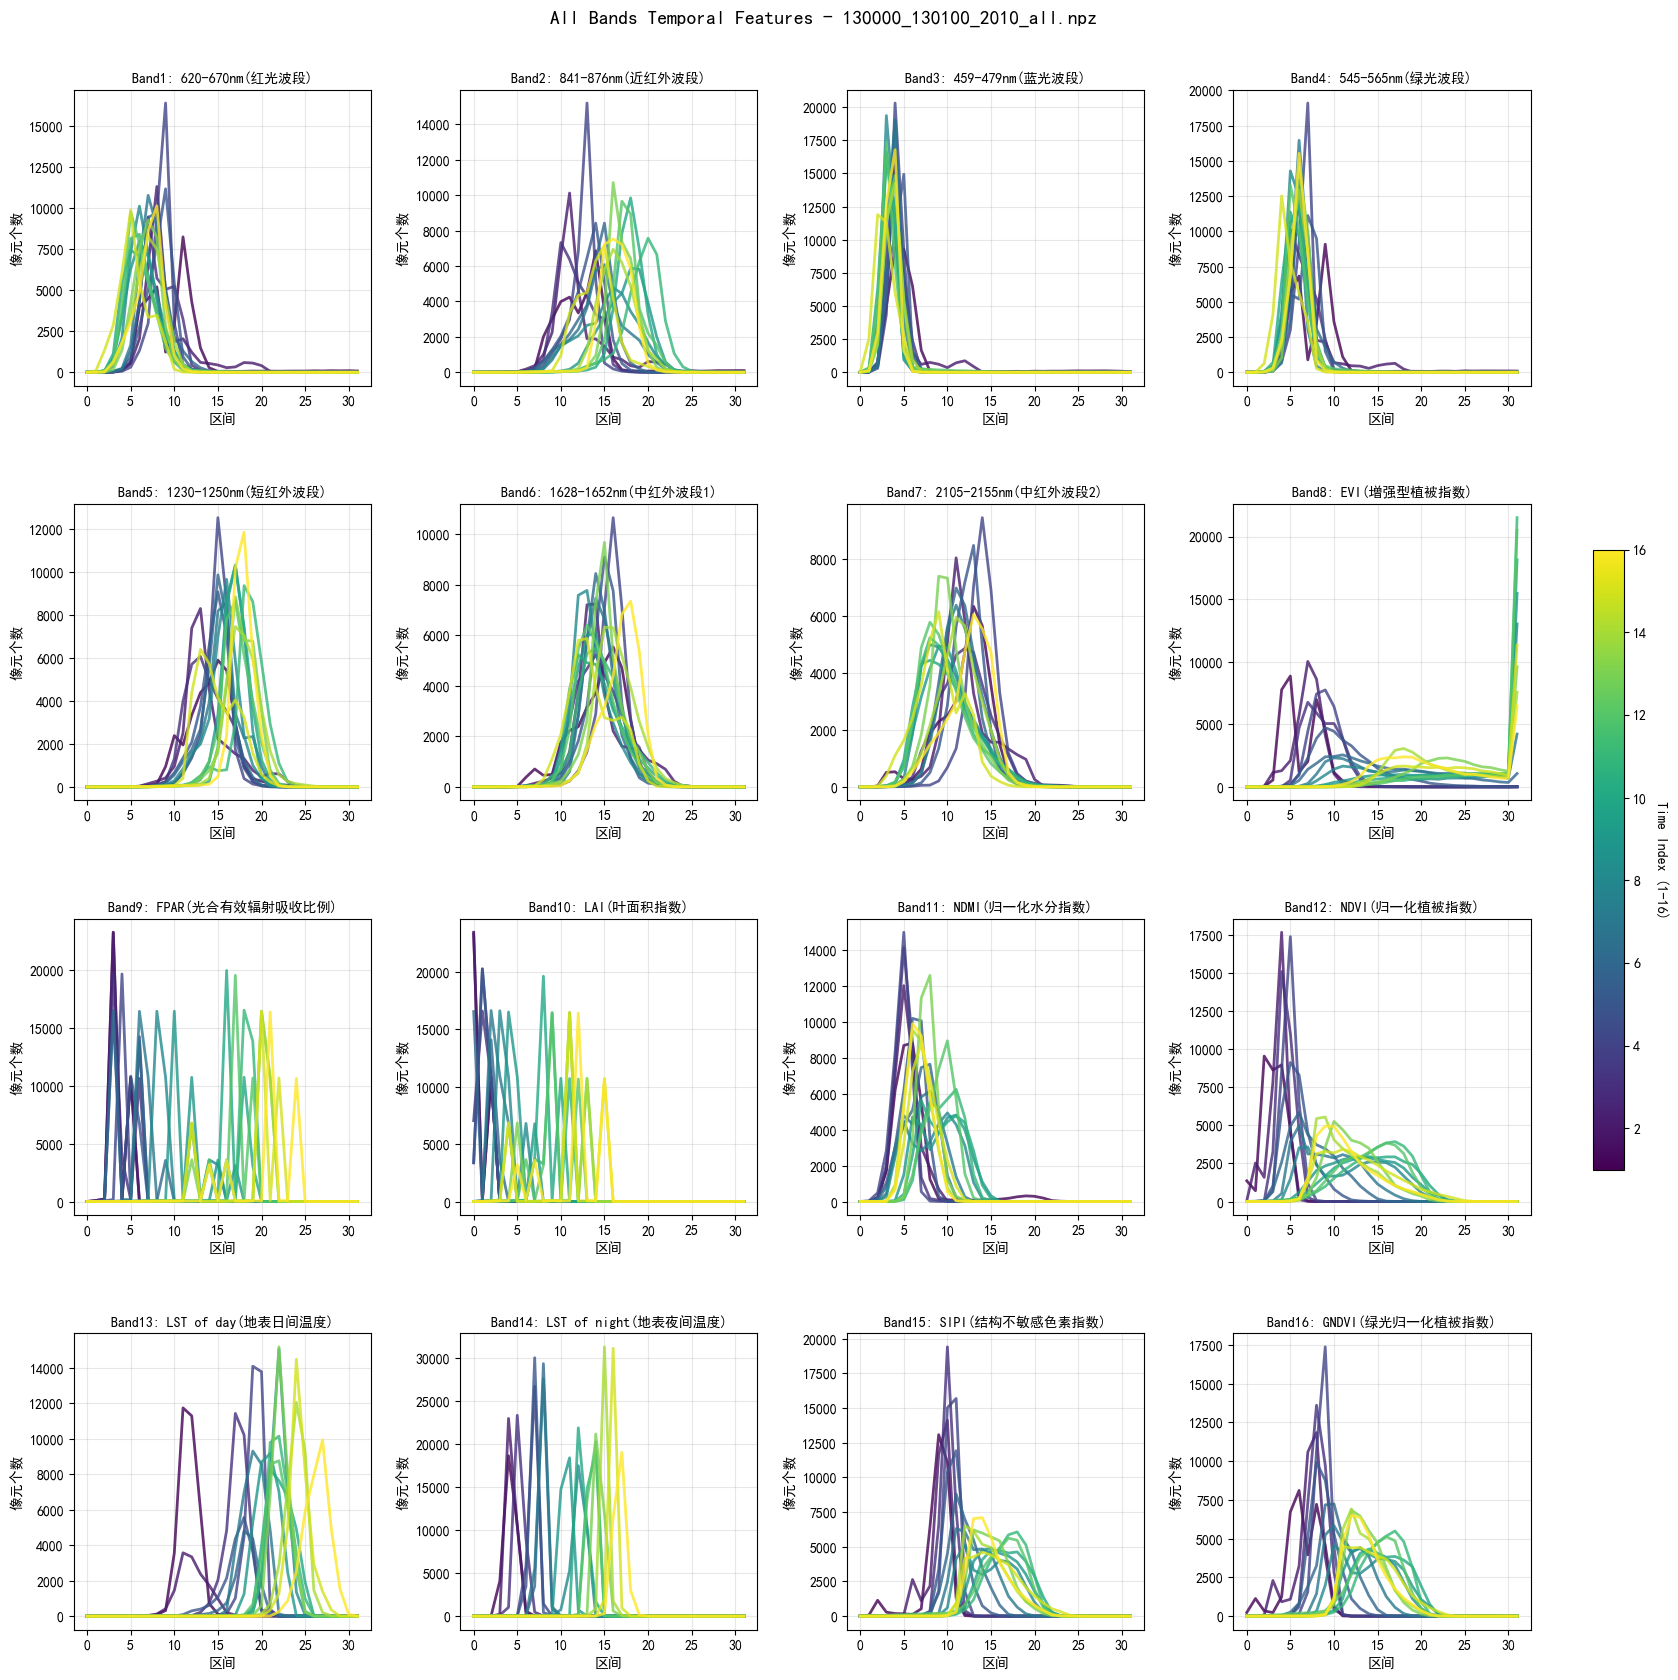

In [ ]:
# 使用示例
visualizer = ModisVisualizer(r"D:\Crop\NorthChina\processed_32")